<br><br><br><br>

<CENTER><font size=12px, face = \"times new roman\">Modélisation Avancée</font></CENTER>

<br><br><br><br>

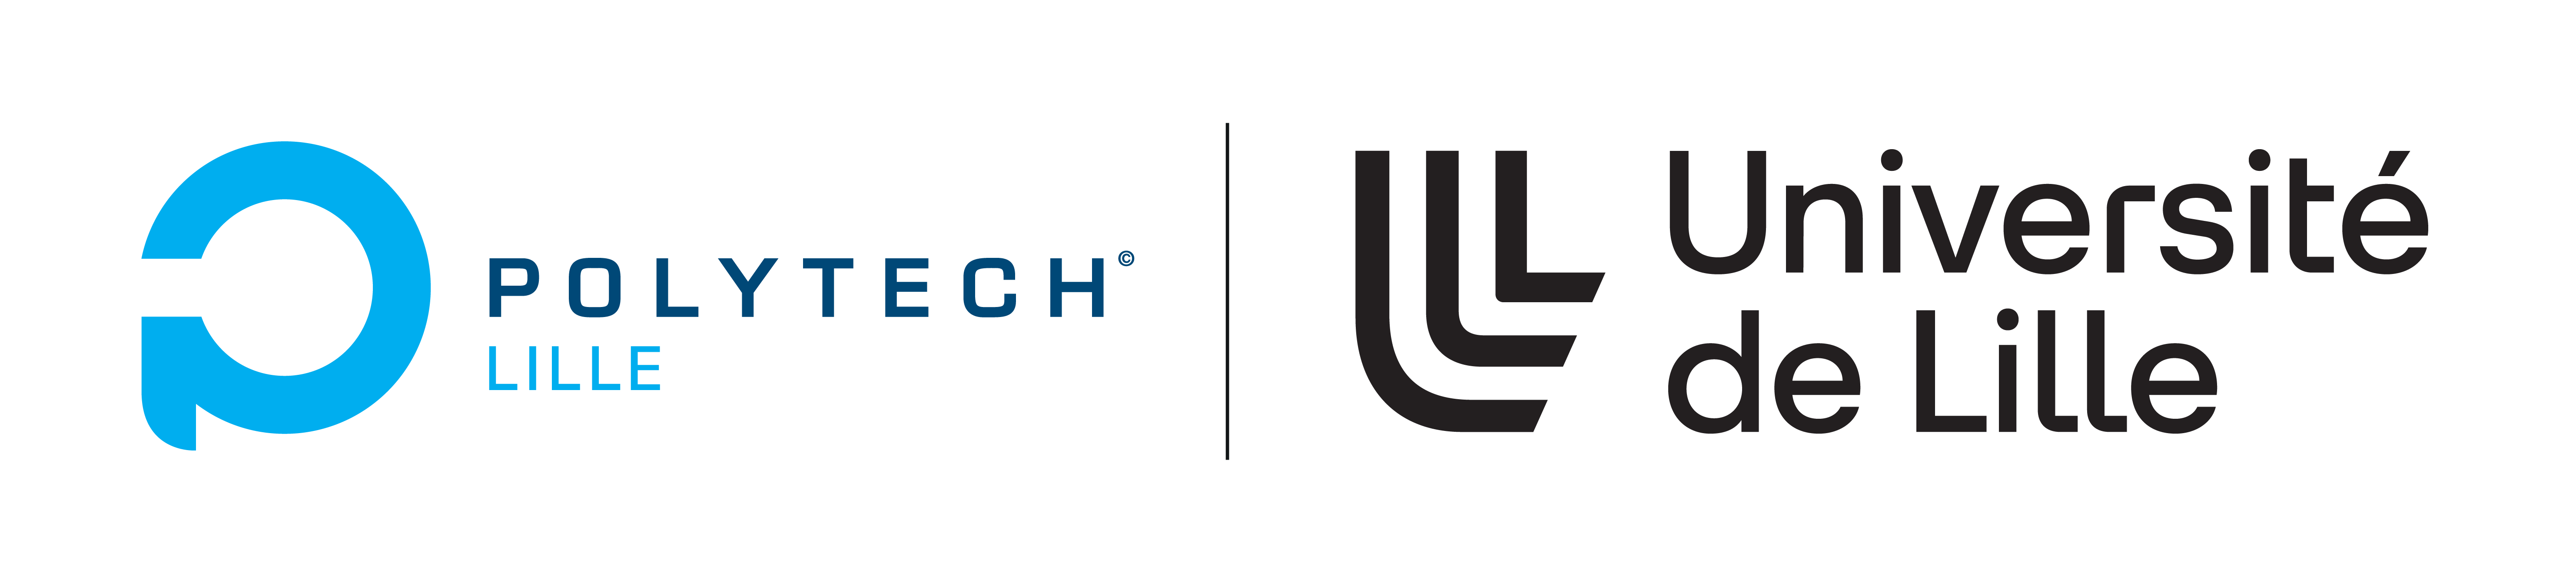

<p><CENTER>Elève:&emsp;MASSON KEVIN  <br>Enseignants:&emsp;PREDA,&ensp;GRIMONPREZ</CENTER></p>

<br><br><br><br>

## DEVOIR MAISON MICE

**Introduction**

Nous possédons un jeu de données sur 32 cranes de deux types (A = mongolian et B = Indian) pour lesquels on
connait 5 caractéristiques numériques.<br>
Le but est de construire un modèle prédictif du type de crane à partir des caractéristiques numériques (X1 - X5) à l’aide de la régression logistique binaire.

<br><br><br><br><br><br><br><br>

**Importation des packages nécessaires**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.imputation import mice
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics

**Importation du jeu de données**

In [2]:
data = pd.read_csv('tibetan_skull_missing.csv', sep = ';')

In [3]:
data.head()

,length,breadth,height,face_height,face_breadth,type
0,190.5,152.5,145.0,73.5,136.5,A
1,172.5,132.0,125.5,63.0,121.0,A
2,167.0,130.0,125.5,69.5,119.5,A
3,169.5,150.5,133.5,64.5,128.0,A
4,NaN,138.5,126.0,77.5,135.5,A


Nous allons regarder les différents types des variables.<br>Vérifier les types de chaques données est très important avant d'effectuer des calculs.

In [4]:
data.dtypes

length          float64
breadth         float64
height          float64
face_height     float64
face_breadth    float64
type             object
dtype: object

**Statistiques univariées descriptives**

Afin d'effectuer des calculs, nous allons transformer la colonne "type" en variable binaire 0,1.

In [5]:
data['type'].unique()

array(['A', nan, 'B'], dtype=object)

In [6]:
data['type'] = data['type'].dropna().map({'A':0,'B':1}).astype(float)

In [7]:
print(data.shape)
data.describe()

(32, 6)


,length,breadth,height,face_height,face_breadth,type
count,29.000000,31.000000,31.000000,30.000000,30.000000,31.000000
mean,180.637931,139.193548,133.322581,72.866667,133.750000,0.483871
std,9.546780,6.913366,6.181354,5.527257,7.322321,0.508001
min,162.500000,126.500000,121.500000,62.000000,118.500000,0.000000
25%,173.500000,134.750000,129.250000,69.625000,131.625000,0.000000
50%,179.500000,139.000000,133.500000,73.500000,134.500000,0.000000
75%,185.000000,142.500000,137.250000,76.500000,136.500000,1.000000
max,200.000000,153.000000,145.000000,82.500000,146.500000,1.000000


**Statistiques bivariées**

In [8]:
data.corr()

,length,breadth,height,face_height,face_breadth,type
length,1.000000,0.054424,0.434489,0.780812,0.613880,0.617264
breadth,0.054424,1.000000,0.025152,0.076701,0.513057,-0.067503
height,0.434489,0.025152,1.000000,0.319862,0.254873,0.236547
face_height,0.780812,0.076701,0.319862,1.000000,0.604771,0.639658
face_breadth,0.613880,0.513057,0.254873,0.604771,1.000000,0.455856
type,0.617264,-0.067503,0.236547,0.639658,0.455856,1.000000


D'après la matrice des corrélations, le type de crane semble etre correlé positivement avec la longueur et la hauteur du visage puisque leurs valeurs de corrélations sont proches de 1 (implique corrélation positive). Ainsi, l'augmentation de la longueur du crane ou de la hauteur du visage semble impliquer qu'il y a plus de chances que le crane soit de type B: Indian.

<br><br><br><br><br><br><br><br><br><br><br><br>

**Visualisations sur les valeurs manquantes**

In [9]:
print(data.isnull().sum())

length          3
breadth         1
height          1
face_height     2
face_breadth    2
type            1
dtype: int64


L'intéret de cette méthode permet d'avoir une première vision du nombre de valeur manquante.<br>
Cependant, cette méthode ne nous renseigne pas si un meme individu possède possède plusieurs valeurs manquantes.

In [10]:
imp = mice.MICEData(data, k_pmm=5)

In [11]:
def get_missing_pattern(miceData):
    cols = miceData.data.columns

    miss = np.zeros(miceData.data.shape)
    
    for j, col in enumerate(cols):
        ix = miceData.ix_miss[col]
        miss[ix, j] = 1
    miss = pd.DataFrame(miss, columns=cols, dtype=int)

    count = miss.groupby(list(cols)).size()
    count = count.reset_index()
    count.rename({0: "count"}, axis=1, inplace=True)

    return count

In [12]:
get_missing_pattern(imp)

,length,breadth,height,face_height,face_breadth,type,count
0,0,0,0,0,0,0,23
1,0,0,0,0,0,1,1
2,0,0,0,0,1,0,1
3,0,0,0,1,0,0,2
4,0,0,1,0,0,0,1
5,0,1,0,0,1,0,1
6,1,0,0,0,0,0,3


Cette fonction (récupérée dans le cours de TP de M. Grimonprez) permet de pouvoir visualiser si des individus possèdent plusieurs valeurs manquantes, par exemple on peut remarquer qu'un crane possède les valeurs manquantes 'breadth' et 'face_breadth' simultanément.

<br><br>

**Visualisation graphique des valeurs manquantes**

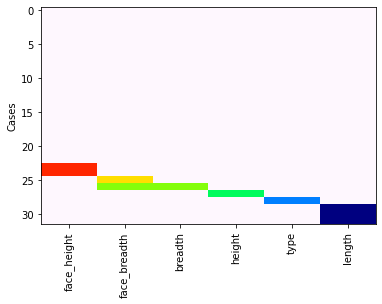

In [13]:
ax = imp.plot_missing_pattern()

Cette visualisation est similaire à nos résultats précèdent et souligne les variables dans lesquelles les valeurs manquantes sont plus importantes(épaisseur axe y). <br>
On remarque aussi les groupes de valeurs manquantes (face_breadth et breadth en vert).

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

**Vérifactions des croisements**

Algorithme comparant les distributions entre 2 variables:

In [14]:
def compare_distribution(X, variable1, variable2):
    fig, ax = plt.subplots(nrows=3, ncols=3, sharex="col", sharey="row",
                           gridspec_kw={"width_ratios": [4, 0.5, 1.25],
                                        "height_ratios": [4, 0.5, 1.25]})

    # create a categorical variable indicating if the value is missing or not
    X_temp = X.copy()
    X_temp["var1_status"] = np.array(["present", "miss"])[np.isnan(X[variable1]) * 1]
    X_temp["var2_status"] = np.array(["present", "miss"])[np.isnan(X[variable2]) * 1]

    # plot the non-missing values
    sns.scatterplot(data=X, x=variable1, y=variable2, ax=ax[0, 0])

    # plot the variable2 values when the variable1 is missing
    sns.scatterplot(data=X_temp[X_temp["var1_status"] == "miss"], x=0, y=variable2, color="tab:orange", ax=ax[0, 1])
    ax[0, 1].axes.xaxis.set_visible(False)

    # boxplot of variable2 with regards to the fact that variable1 is missing or not
    sns.boxplot(data=X_temp, x="var1_status", y=variable2, ax=ax[0, 2])
    ax[0, 2].yaxis.label.set_visible(False)
    ax[0, 2].xaxis.label.set_visible(False)

    # plot the variable1 values when the variable2 is missing
    sns.scatterplot(data=X_temp[X_temp["var2_status"] == "miss"], x=variable1, y=0, color="tab:orange", ax=ax[1, 0])
    ax[1, 0].axes.yaxis.set_visible(False)

    # boxplot of variable1 with regards to the fact that variable2 is missing or not
    sns.boxplot(data=X_temp, x=variable1, y="var2_status", orient="h", ax=ax[2, 0])
    ax[2, 0].yaxis.label.set_visible(False)

    ax[1, 1].axis("off")
    ax[1, 2].axis("off")
    ax[2, 1].axis("off")
    ax[2, 2].axis("off")
    fig.suptitle("")
    
    return ax

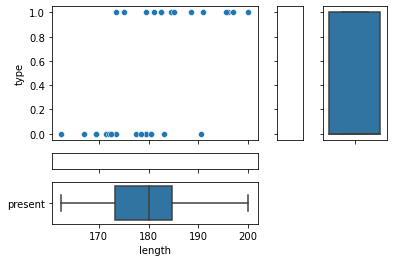

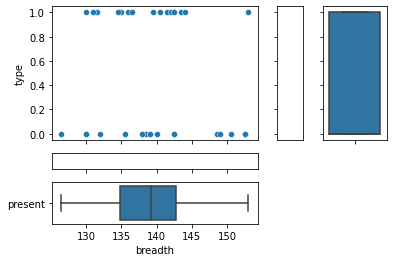

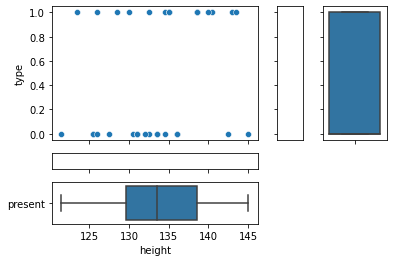

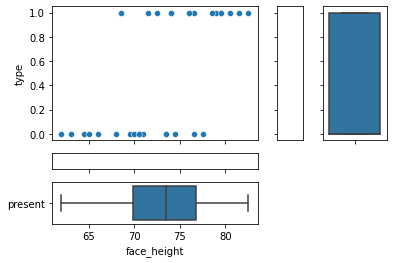

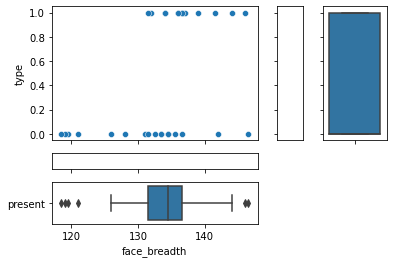

In [27]:
#Nous allons maintenant comparer les distributions de nos variables :
for i in data.iloc[:,0:5].columns:
    print('\n')
    compare_distribution(data, i, "type")
    plt.show()

Le nombre de valeurs manquantes étant faible, il est difficile d'effectuer une comparaison de la distribution de nos variables.<br>
Cependant, on remarque des extremums sur breadth et height. Cela pourrait etre expliquer la présence de valeurs manquante, mais en raison de la petite taille du jeu de données on ne peut pas certifier cette observation.

<br><br><br><br><br><br><br><br><br><br><br><br>

**Regression logistique dans le contexte de l’imputation multiple**

J'ai donc décidé de choisir les 3 variables : length, face_height, face_breadth afin d'effectuer ma régression logistique.

In [16]:
formula = "type ~ length + face_height + face_breadth"
mice_fit = mice.MICE(formula, sm.Logit, imp, n_skip=3)
results = mice_fit.fit(n_burnin=5, n_imputations=10)

Optimization terminated successfully.
         Current function value: 0.390470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390645
  

In [17]:
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: MICE
=====================================================================
Method:                     MICE         Sample size:            32  
Model:                      Logit        Scale                   1.00
Dependent variable:         type         Num. imputations        10  
---------------------------------------------------------------------
              Coef.   Std.Err.    t    P>|t|   [0.025   0.975]  FMI  
---------------------------------------------------------------------
Intercept    -42.6561  19.1909 -2.2227 0.0262 -80.2696 -5.0426 0.0931
length         0.1017   0.0923  1.1014 0.2707  -0.0793  0.2827 0.1550
face_height    0.2331   0.1597  1.4596 0.1444  -0.0799  0.5461 0.0689
face_breadth   0.0534   0.1119  0.4769 0.6334  -0.1660  0.2727 0.0530
=====================================================================

"""

La statistique *FMI* représente la part de variance de l’estimateur due à l’imputation. Une valeur trop grande montre que l’imputation est probablement inappropriée dans ce cas. Une valeur < 0.3 est généralement tolérée.<br>
Dans notre situation, nous avons des valeurs de FMI < 0.3, ainsi notre imputation semble appropriée.

In [18]:
n_imputation = 10
n_burn_iter = 5

imp.update_all(n_burn_iter)  # n_burn_iter itérations sans sauvegarder

imputed_data = []
for m in range(n_imputation):
    data = imp.next_sample()  # effectue 1 itération et retourne les données
    imputed_data.append(data.copy())  # on sauvegarde les données
    
#Affichage d'un des 10 jeux de données avec valeurs imputées
print(imputed_data[9].head())

   length  breadth  height  face_height  face_breadth  type
0   190.5    152.5   145.0         73.5         136.5   0.0
1   172.5    132.0   125.5         63.0         121.0   0.0
2   167.0    130.0   125.5         69.5         119.5   0.0
3   169.5    150.5   133.5         64.5         128.0   0.0
4   180.5    138.5   126.0         77.5         135.5   0.0


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

**Exemple de régression logistique sur un jeu de données après imputation MICE**

In [19]:
#On choisit un jeu de données après imputation MICE
imp_data = imputed_data[9]

#On sélectionne les colonnes sur lesquelles on souhaite effectuer notre régression logistique
X_cols = ['length', 'face_height', 'face_breadth']
y_col = 'type'

# Sépare les données imputées en variables indépendantes et dépendante
X = imp_data[X_cols]
y = imp_data[y_col]

# Effectue la régression logistique avec les données imputées

logit_model = sm.Logit(y, sm.add_constant(X))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.417436
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                   32
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                  0.3961
Time:                        13:02:12   Log-Likelihood:                -13.358
converged:                       True   LL-Null:                       -22.118
Covariance Type:            nonrobust   LLR p-value:                 0.0005523
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -44.0207     19.260     -2.286      0.022     -81.769      -6.272
length           0.1118

**Courbe ROC du modèle logistique obtenu + Taux de mal classés**

Le Modele  1  a pour taux de Mal Classées :  0.156
Le Modele  2  a pour taux de Mal Classées :  0.219
Le Modele  3  a pour taux de Mal Classées :  0.188
Le Modele  4  a pour taux de Mal Classées :  0.188
Le Modele  5  a pour taux de Mal Classées :  0.188
Le Modele  6  a pour taux de Mal Classées :  0.188
Le Modele  7  a pour taux de Mal Classées :  0.156
Le Modele  8  a pour taux de Mal Classées :  0.188
Le Modele  9  a pour taux de Mal Classées :  0.188


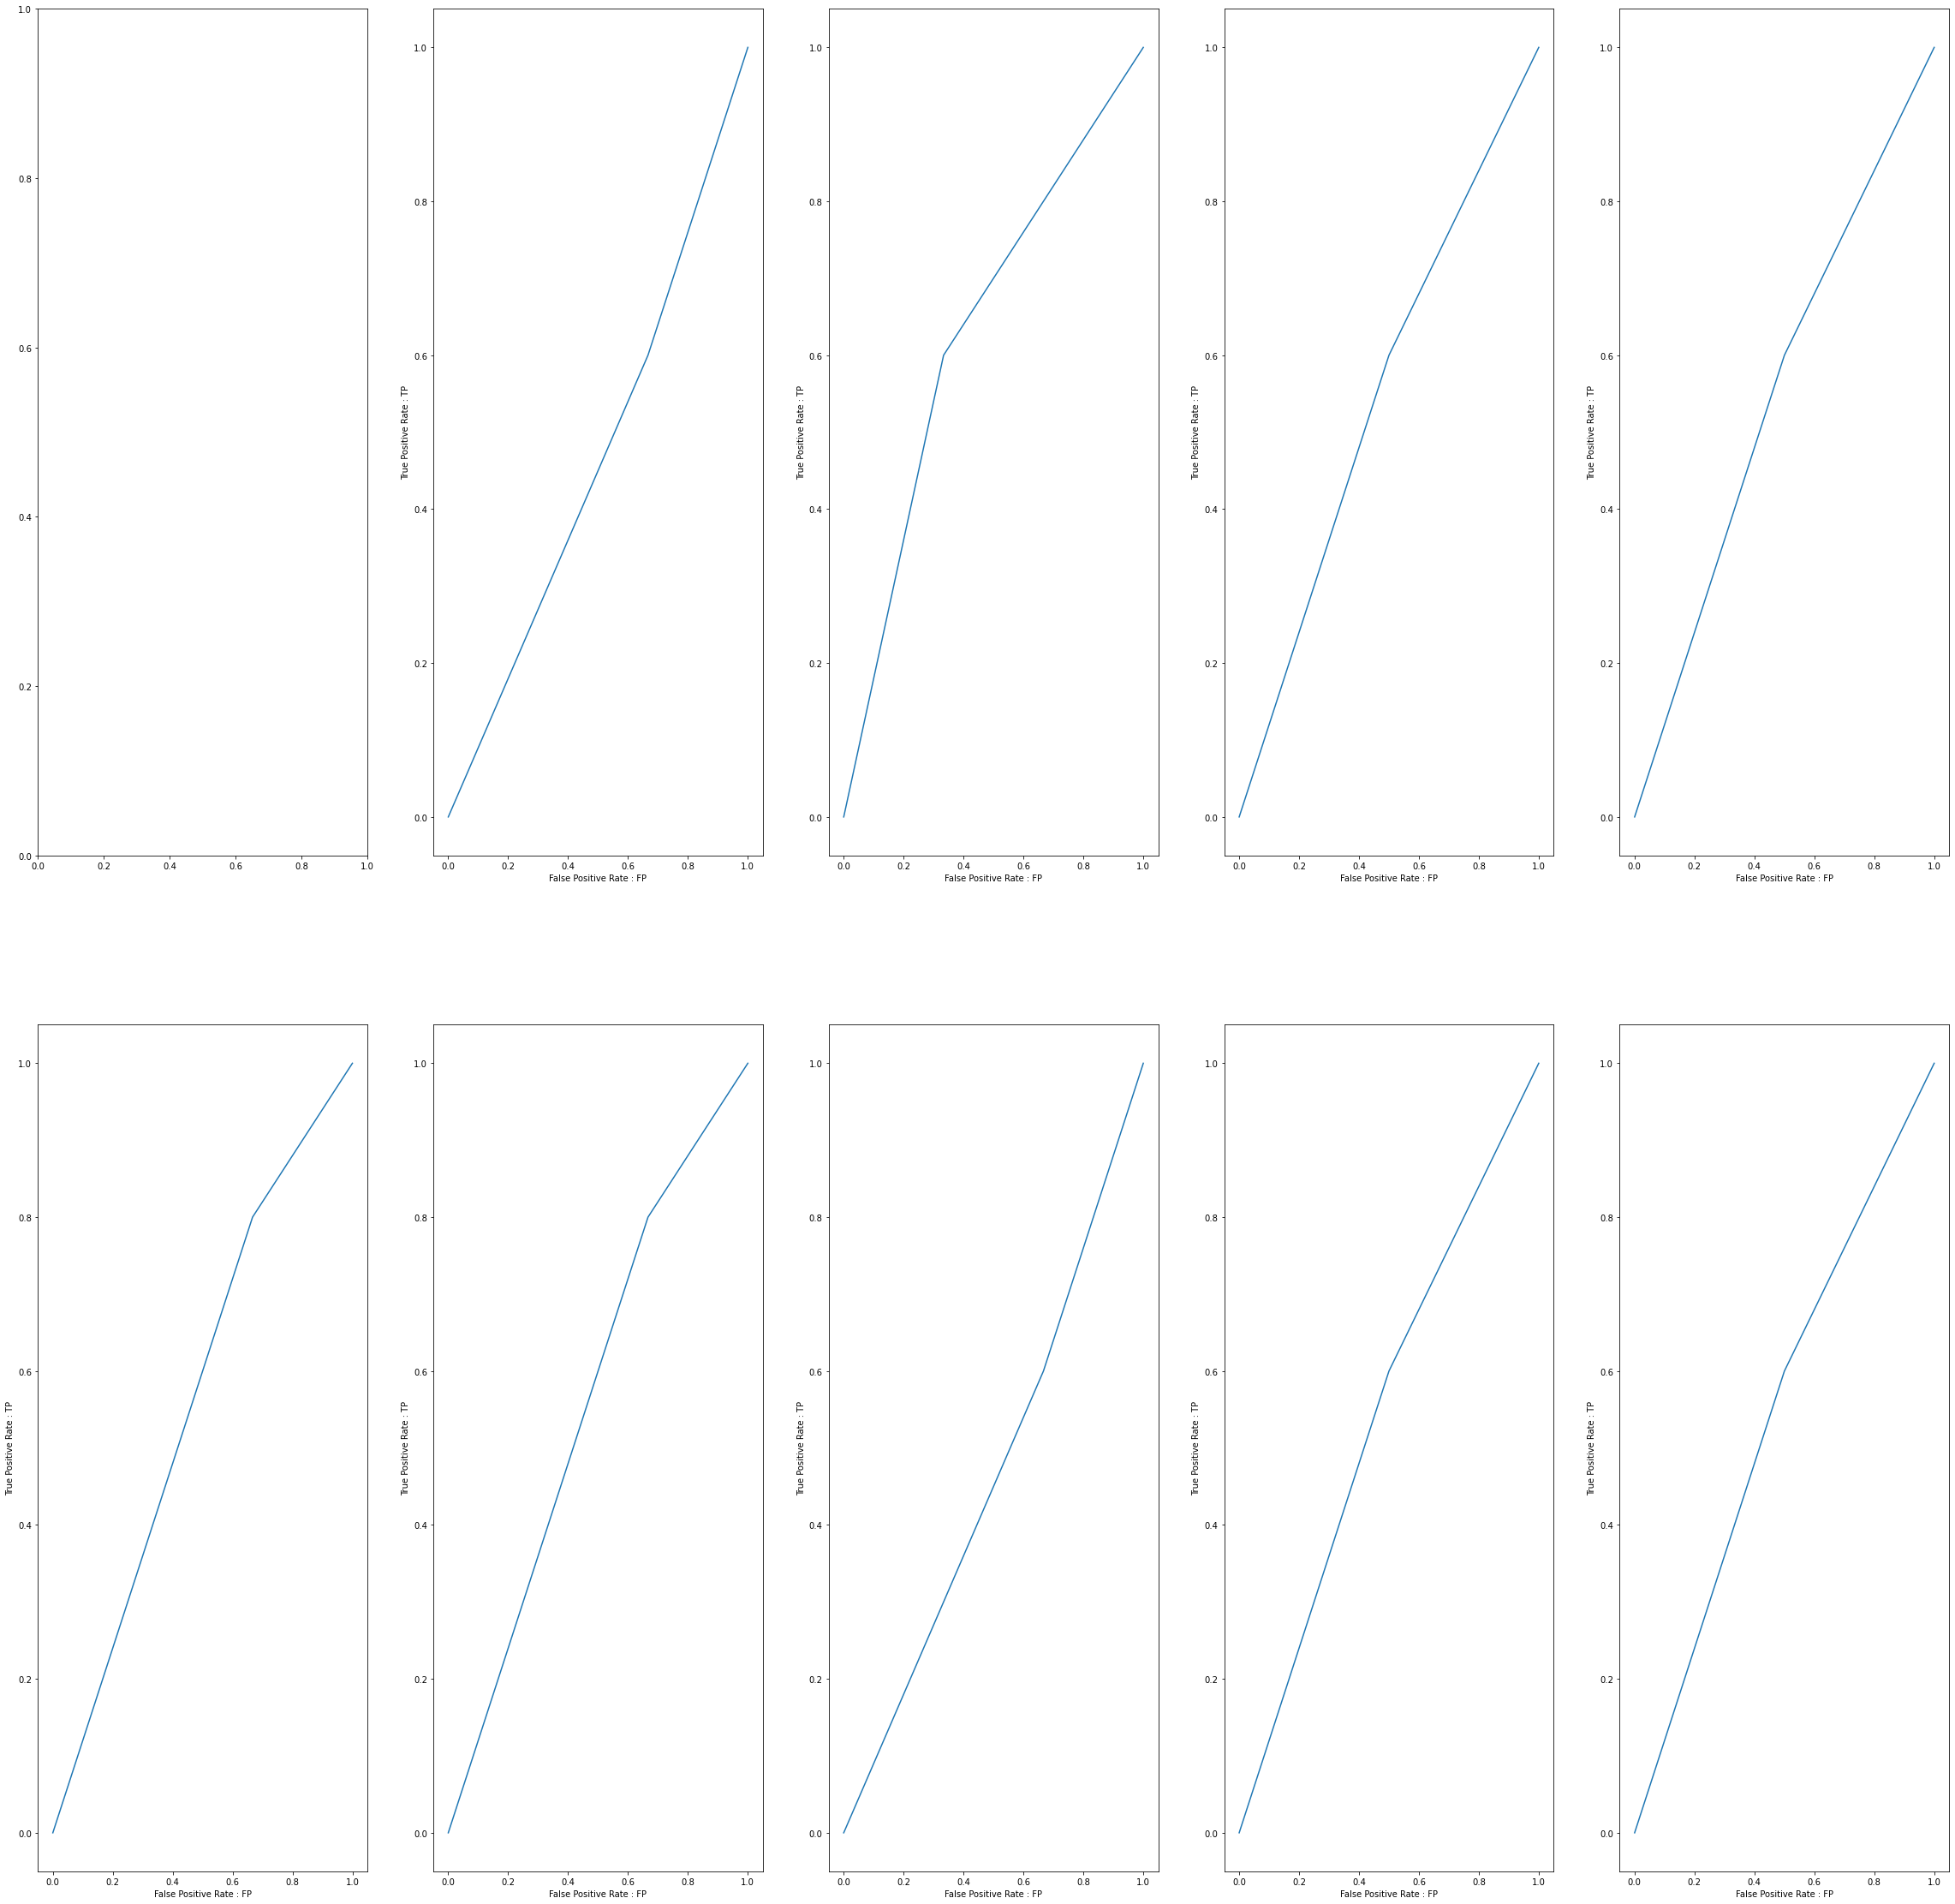

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(40, 40))
for i in range(1,10):
    d = pd.DataFrame(imputed_data[i])
    d["type"] = (data["type"]).astype(int)
    
    ### On effectue un test de chi2 afin de déterminer quelles sont les features à conserver.
    chi2_s = SelectKBest(chi2, k = 3) ## On sélectionné 3 var.
    X = chi2_s.fit_transform(imputed_data[i], d["type"])
    X = pd.DataFrame(X)
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 0:2], d["type"], test_size=0.33, random_state=42)
    log_reg = sm.Logit(y_train, X_train).fit(disp = False)
    y = log_reg.predict(X_test)
    pred = [1 if p > 0.5 else 0 for p in y]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

    #Courbe ROC
    AUC = metrics.auc(fpr, tpr)
    
    # Affichage de la courbe ROC
    #Parametrage de la courbe
    r = i // 5
    c = i % 5
    ax = axes[r][c]
    ax.plot(fpr, tpr, label="AUC = {:.2f}".format(AUC))
    ax.set_xlabel("False Positive Rate : FP")
    ax.set_ylabel("True Positive Rate : TP")
    
    #Calcul des valeurs 
    tn, fp, fn, tp = metrics.confusion_matrix(list(y_test.values), pred).ravel()
    tauxMalClassee = (tp + tn)/d.shape[0]
    print("Le Modele ", i ," a pour taux de Mal Classées : ", np.round(tauxMalClassee,3))
plt.show()  

<br><br><br><br><br><br><br><br><br><br><br><br><br>

Ainsi, on obtient des taux de mal classées correctes. Ce résultat est cohérent puisque notre jeu de données est de petite taille avec peu de valeurs manquantes. Ainsi, nos imputations et régressions fonctionnent relativement bien. 